# Vectorizacion de texto

# MODELO 1.

In [1]:
#  TOPIC MODELING
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json
import glob
import re
from pprint import pprint

def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = pd.read_csv(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [2]:
def remove_stops(text, stops):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+','',text)
    text = re.sub(r'[^\w\s -]','',text)
    text = re.sub(r'-',' ',text)
    text = text.lower()
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def clean_docs(docs):
    stops = stopwords.words("spanish")
    final = []
    for doc in docs:
        #clean_doc = remove_stops(doc, stops)
        final.append(doc)
    return (final)

In [3]:
encontrado = load_data("titulosEncontrados.csv")
candidato = load_data("titulosCandidatos.csv")
# print (descriptions[0])
candidato = candidato.dropna()
encontrado = encontrado.dropna()
titEncontrado = clean_docs(encontrado['titulo'])
titCandidato = clean_docs(candidato['titulo'])
# print (cleaned_docs[0])


In [4]:
dfTitCandidato = pd.read_csv('df_titulosCandidatos.csv', sep=',',  encoding='utf-8')
dfTitEncontrado = pd.read_csv('df_titulosEncontrados.csv', sep=',',  encoding='utf-8')

In [5]:
stops = stopwords.words("spanish")

vectorizer = TfidfVectorizer(
                                lowercase=False,
                                use_idf=True,
                                max_features=20000,
                                max_df=0.99,
                                min_df=50,
                                ngram_range = (1,3),
                                stop_words = stops
                                

                            )

vectorizer.fit(titEncontrado)
vectorsCandidatos = vectorizer.transform(titCandidato)
vectorsEncontrado = vectorizer.transform(titEncontrado)
feature_names = vectorizer.get_feature_names_out()




In [6]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(vectorsCandidatos, vectorsEncontrado)

In [7]:
dist.shape

(10105, 5286)

In [8]:
import seaborn as sns
import numpy as np

result = np.where(dist > 0.8)  #buscar como se utiliza


In [9]:
#sns.heatmap(htm)

In [10]:
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectorsEncontrado)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open ("clusters_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [11]:
#terms

## CountVectorizer

In [62]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

encontrado = load_data("titulosEncontrados.csv")['titulo']
coun_vect = CountVectorizer(lowercase=True, analyzer="word", ngram_range=(1,4),max_features = 100)
coun_vect.fit(titEncontrado)
count_candidatos = coun_vect.transform(titCandidato)
count_encontrados = coun_vect.transform(titEncontrado)
count_array = count_candidatos.toarray()
dfCountVec = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())
dfCountVec

,actor,actora,analisis,analisis integral,analisis integral problematica,analisis integral problematica tecnicas,antecedentes,antecedentes autos,antecedentes autos interes,antecedentes autos interes medico,...,puntos,puntos pericia,puntos pericia solicitados,puntos periciales,realizacion,respuesta,respuesta puntos,respuesta puntos pericia,solicitados,tecnicas
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
print(coun_vect.vocabulary_)

{'antecedentes': 6, 'interes': 58, 'medico': 67, 'legal': 61, 'antecedentes interes': 10, 'interes medico': 59, 'medico legal': 68, 'antecedentes interes medico': 11, 'interes medico legal': 60, 'antecedentes interes medico legal': 12, 'examen': 44, 'fisico': 48, 'actor': 0, 'examen fisico': 46, 'consideraciones': 27, 'legales': 62, 'consideraciones medico': 28, 'medico legales': 69, 'consideraciones medico legales': 29, 'conclusiones': 24, 'incapacidad': 54, 'contestacion': 34, 'puntos': 90, 'pericia': 78, 'contestacion puntos': 35, 'puntos pericia': 91, 'contestacion puntos pericia': 36, 'petitorio': 83, 'autos': 13, 'perito': 81, 'oficio': 72, 'examen perito': 47, 'periciales': 80, 'puntos periciales': 93, 'bibliografia': 17, 'historia': 50, 'clinica': 20, 'historia clinica': 51, 'estudios': 41, 'solicitados': 98, 'conclusiones medico': 25, 'conclusiones medico legales': 26, 'evaluacion': 43, 'datos': 37, 'personales': 82, 'datos personales': 38, 'hechos': 49, 'complementarios': 23,

In [64]:
print(coun_vect.get_feature_names_out())

['actor' 'actora' 'analisis' 'analisis integral'
 'analisis integral problematica'
 'analisis integral problematica tecnicas' 'antecedentes'
 'antecedentes autos' 'antecedentes autos interes'
 'antecedentes autos interes medico' 'antecedentes interes'
 'antecedentes interes medico' 'antecedentes interes medico legal' 'autos'
 'autos interes' 'autos interes medico' 'autos interes medico legal'
 'bibliografia' 'cabo' 'cabo para' 'clinica' 'clinica actor' 'columna'
 'complementarios' 'conclusiones' 'conclusiones medico'
 'conclusiones medico legales' 'consideraciones' 'consideraciones medico'
 'consideraciones medico legales' 'consideraciones medicolegales'
 'contesta' 'contesta puntos' 'contesta puntos pericia' 'contestacion'
 'contestacion puntos' 'contestacion puntos pericia' 'datos'
 'datos personales' 'demandada' 'diagnostico' 'estudios'
 'estudios complementarios' 'evaluacion' 'examen' 'examen actor'
 'examen fisico' 'examen perito' 'fisico' 'hechos' 'historia'
 'historia clinica' '

In [65]:
coun_vect.get_feature_names_out()

array(['actor', 'actora', 'analisis', 'analisis integral',
       'analisis integral problematica',
       'analisis integral problematica tecnicas', 'antecedentes',
       'antecedentes autos', 'antecedentes autos interes',
       'antecedentes autos interes medico', 'antecedentes interes',
       'antecedentes interes medico', 'antecedentes interes medico legal',
       'autos', 'autos interes', 'autos interes medico',
       'autos interes medico legal', 'bibliografia', 'cabo', 'cabo para',
       'clinica', 'clinica actor', 'columna', 'complementarios',
       'conclusiones', 'conclusiones medico',
       'conclusiones medico legales', 'consideraciones',
       'consideraciones medico', 'consideraciones medico legales',
       'consideraciones medicolegales', 'contesta', 'contesta puntos',
       'contesta puntos pericia', 'contestacion', 'contestacion puntos',
       'contestacion puntos pericia', 'datos', 'datos personales',
       'demandada', 'diagnostico', 'estudios', 'estudio

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(count_candidatos, count_encontrados)

In [67]:
dist.shape

(10105, 5286)

# *****************************************************************

# BUSQUEDA DE TITULOS CANDIDATOS

In [68]:
def buscartitulo(tituloE, tituloC):
    titEncontrados = []
    for titulo in tituloE:
        for candidato in tituloC:
            if titulo == candidato:
                titEncontrados.append(candidato)
    return titEncontrados

    

In [69]:
encontradosTokens = encontrado.value_counts().head(100)

In [72]:
candidatoToken = candidato.value_counts().head(500)

In [73]:
def listartitulos(tokens):
    listTit=[]
    for i,j in tokens.items():
        i = remove_stops(str(i),stops)
        listTit.append(i)
    return listTit

In [74]:
candidatosList = listartitulos(candidatoToken)
encontradosList = listartitulos(encontradosTokens)

In [75]:
candidatosEncontrados = buscartitulo(encontradosList, candidatosList)

In [76]:
candidatosEncontrados

['conclusiones',
 'consideraciones medico legales',
 'antecedentes autos interes medico legal',
 'contestacion puntos pericia',
 'hechos',
 'conclusiones medico legales',
 'objeto',
 'consideraciones medicolegales',
 'datos personales',
 'examen actor',
 'examen fisico',
 'bibliografia',
 'estudios complementarios',
 'respuesta puntos pericia',
 'puntos periciales',
 'puntos pericia',
 'incapacidad',
 'examen actora',
 'identificacion actor',
 'columna cervical',
 'conclusiones medicolegales',
 'conclusion',
 'constancias autos',
 'medico',
 'incapacidad actual',
 'antecedentes personales']

# Búsqueda de títulos en los títulos candidatos

In [107]:
# Buscar_candidatos: compara títulos candidatos con el diccionario te títulos candidatos=encontrados
def buscar_candidatos(encontrado, candidato, ide, inicio, fin):
    indiceEncontrados=[]
    for i in range(len(candidato)):
        for e in encontrado:
            if candidato[i] == e:
                indiceEncontrados.append((ide[i],candidato[i], inicio[i], fin[i]))
    return indiceEncontrados

In [119]:
# Lista con los títulos candidatos que son títulos de sección, su índice y ubicación
indicesCandidatos = buscar_candidatos(candidatosEncontrados ,dfTitCandidato.titulo, dfTitCandidato.ide, dfTitCandidato.inicio, dfTitCandidato.fin)

In [ ]:
indiceEncontrados=[]
for i in range(len(dfTitCandidato.titulo)):
    for e in encontrado:
        if dfTitCandidato.titulo[i] == e:
            indiceEncontrados.append((dfTitCandidato.ide[i],dfTitCandidato.titulo[i], dfTitCandidato.inicio[i], dfTitCandidato.fin[i]))


In [110]:
dfUbicacionNuevosEncontrados = pd.DataFrame(indicesCandidatos, columns=['ide', 'titulo', 'inicio', 'fin'])

In [111]:
dfUbicacionNuevosEncontrados.to_csv('df_UbicacionNuevosEncontrados.csv',index=False)
dfUbicacionNuevosEncontrados.to_excel('df_UbicacionNuevosEncontrados.xlsx',index=False)

# ************************************************************

# DISTANCIA COSENO

<AxesSubplot:>

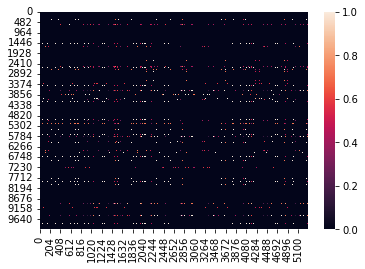

In [25]:
import seaborn as sns
import numpy as np

sns.heatmap(dist)

In [26]:
dist.shape

(10105, 5286)

In [27]:
import numpy
numpy.argmax(dist[0])


31

In [28]:
dist[0][30]

0.4999999999999999

In [29]:
count_array[30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [30]:
coun_vect.get_feature_names_out()

array(['actor', 'antecedentes', 'antecedentes autos',
       'antecedentes autos interes', 'autos', 'autos interes', 'clinica',
       'conclusiones', 'consideraciones', 'consideraciones medico',
       'consideraciones medico legales', 'contestacion',
       'contestacion puntos', 'contestacion puntos pericia', 'examen',
       'hechos', 'historia', 'historia clinica', 'interes',
       'interes medico', 'interes medico legal', 'legal', 'legales',
       'medico', 'medico legal', 'medico legales', 'pericia', 'petitorio',
       'puntos', 'puntos pericia'], dtype=object)

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
#prueba de vectorizador
coun_vect = CountVectorizer(ngram_range=(1,4),max_features = 100)
coun_vect.fit(encontradosList)
countV_candidatos = coun_vect.transform(candidatosList)
countV_encontrados = coun_vect.transform(encontradosList)
count_array = countV_candidatos.toarray()
dfCountVec = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())

In [32]:
dfCountVec

,actor,actora,actual,analizada,antecedentes,antecedentes autos,antecedentes autos interes,antecedentes autos interes medico,antecedentes personales,autos,...,recomendaciones,relato,relato hechos,respiratorio,respuesta,respuesta puntos,respuesta puntos pericia,solicitados,tecnicas,utilizados
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
from sklearn.metrics.pairwise import cosine_similarity
distPrueba = cosine_similarity(countV_candidatos, countV_encontrados)

In [34]:
distPrueba.shape

(500, 100)

<AxesSubplot:>

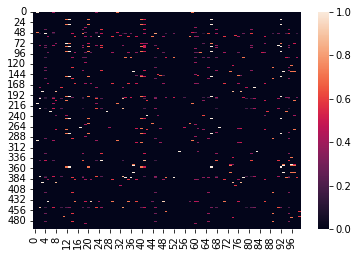

In [35]:
sns.heatmap(distPrueba)

In [36]:
import numpy
numpy.argmax(distPrueba, axis=1)

array([ 2,  0,  1,  0,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0, 37,  0,  6,
        0, 13,  0,  0,  0,  0,  0, 89,  0, 12,  0,  0, 13,  0,  0, 17,  0,
        0, 25, 19,  0,  0,  0,  0, 25,  7,  0,  0,  0, 37, 46,  1, 17,  4,
       59,  0,  0, 75,  0, 18, 24,  0,  0,  0,  0, 91,  0,  0, 25,  0,  0,
        0,  1,  0,  0,  0, 12, 15,  0, 37, 91, 19, 11, 13, 91, 25,  0, 46,
        0,  0,  0,  0,  0, 91, 13,  0,  0, 62,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 34,  0,  0,  0,  0,  0, 10,  0,  0,  0,  3,  0, 19, 12,
        0, 13,  0,  0, 96,  0,  0,  0, 25, 89,  0,  0, 76, 62,  0,  0, 25,
        0, 37,  0,  0,  0,  0,  0, 89, 46, 89, 76,  0,  0, 13,  0,  0,  0,
       89, 89,  0,  0, 51,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,
        0,  0,  0,  0, 82,  0,  0,  0, 24,  0,  0,  0,  0,  3,  0,  0,  0,
       12,  0,  0,  0, 19,  0, 13,  0, 13,  0, 34,  0,  2, 12,  0,  0,  0,
       12,  0,  0,  2,  0,  0, 37,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0

In [37]:
ind = np.unravel_index(np.argmax(distPrueba, axis=None), distPrueba.shape)

In [38]:
distPrueba[ind]

1.0000000000000002

In [39]:
index_array = np.argmax(distPrueba, axis=-1)
np.take_along_axis(distPrueba, np.expand_dims(index_array, axis=-1), axis=-1)

array([[1.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.57735027],
       [0.40824829],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.57735027],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.577

In [40]:
distanciaCoseno=[]
for e in countV_encontrados:
   m=-1
   ind=0
   for c in countV_candidatos:
      
      
      if (cosine_similarity(c,e)) > m:
         m=(cosine_similarity(c,e))
         ind=c.indices
         #pprint(cosine_similarity(c,e))
      arreglo=(ind,m)
   distanciaCoseno.append(arreglo)


In [41]:
distanciaCoseno

[(array([20, 21, 22, 52, 68, 71]), array([[0.]])),
 (array([17]), array([[1.]])),
 (array([20, 21, 22, 52, 68, 71]), array([[1.]])),
 (array([14, 36, 37]), array([[1.]])),
 (array([ 4,  5,  6,  7,  9, 10, 11, 47, 48, 49, 51, 68, 69]), array([[1.]])),
 (array([25, 26, 27, 82, 87, 88]), array([[1.]])),
 (array([35]), array([[1.]])),
 (array([17, 18, 19, 52, 68, 71]), array([[1.]])),
 (array([14, 36, 37]), array([[0.8660254]])),
 (array([20, 21, 22, 52, 68, 71]), array([[0.]])),
 (array([20, 23, 73]), array([[1.]])),
 (array([28, 84]), array([[1.]])),
 (array([ 0, 34]), array([[1.]])),
 (array([34]), array([[1.]])),
 (array([9]), array([[0.57735027]])),
 (array([82, 87, 88]), array([[1.]])),
 (array([20, 21, 22, 52, 68, 71]), array([[0.]])),
 (array([16, 32, 33]), array([[1.]])),
 (array([ 4, 47, 48, 49, 51, 68, 69]), array([[1.]])),
 (array([82, 87, 88, 94, 95, 96]), array([[1.]])),
 (array([34]), array([[0.70710678]])),
 (array([25, 26, 27, 82, 87, 88]), array([[0.9258201]])),
 (array([

In [42]:
# Test de correlación (coseno) por títulos candidato y título encontrado
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return distancia


In [43]:
correlacion=[]
for c in candidatosList:
    max=-1
    for e in encontradosList:
        corr=similitud_coseno(c,e)
        if corr > max:
            max=corr
        titE=c
    correlacion.append((c,titE,max))

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U30'), dtype('<U9')) -> None